In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.constants as cst
from matplotlib import pyplot

Le but de ce notebook est de vérifier si on peut décrire les vecteurs de inputs (2x101+1) et outputs (2x1001) en peu de variables à partir des composantes principales. Evaluer l'erreur de reconstruction.

In [35]:
tx1 = torch.load('data/tX1.pt')
tx2 = torch.load('data/tX2.pt')
ty = torch.load('data/ty.pt')
        
dataset_size = len(ty)
lambda_ = np.linspace(1500e-9,1600e-9,1001)
omega = 2*np.pi*cst.c/lambda_ 
yi = torch.Tensor(tx1.shape[0],int(tx1.shape[1]/2))
yr = torch.Tensor(tx1.shape[0],int(tx1.shape[1]/2))
y_reshape = torch.reshape(tx1,(tx1.shape[0],2,int(tx1.shape[1]/2)))
yr[:,:] = y_reshape[:,0,:]
yi[:,:] = y_reshape[:,1,:]

x = torch.Tensor(tx2.shape[0],3,int(tx2.shape[1]/2-1))
x_reshape = torch.reshape(tx2,(len(ty),2,101))
x[:,0,:] = ((x_reshape[:,0,:])/50000)
x[:,1,:] = (((x_reshape[:,1,:])-torch.min(x_reshape[:,1,:]))/(torch.max(x_reshape[:,1,:])-torch.min(x_reshape[:,1,:])))
x[:,2,:] = (ty[:,1]/torch.max(ty[:,1])).unsqueeze(-1).expand(len(ty),101)       
X = []
Y = []
Y2 = []
angle = []
data =[] 


for i in range(dataset_size): 
    angle.append(torch.Tensor(np.unwrap(np.angle(yr[i,:].cpu().numpy()+1j*yi[i,:].cpu().numpy()),discont=cst.pi)))
    X.append(x[i])# D.append(X2[i].unsqueeze(0))
    y=10*np.log10(np.abs(yi[i,:]**2+yr[i,:]**2))
    Y.append(10*np.log10(np.abs(yi[i,:]**2+yr[i,:]**2)))#     U.append(10*np.log10(np.abs(Y2[i,:])**2))      
    data .append([x[i],y]) #Data.append([X2[i].unsqueeze(0),Y2[i,:]]) #
    Y2.append(torch.stack([Y[i],angle[i]],0).view(2002))
    
jmX=X
jmY=Y2


In [187]:
#y_reshape (12k x 2 x 1001)
#x_reshape (12k x 2 x 101)
#ty[:,1] (12k x 1)
allPeriod=np.squeeze(x_reshape[:,1,:].numpy())
allKappa=np.squeeze(x_reshape[:,0,:].numpy())
allN=np.expand_dims(ty[:,1] .numpy(),axis=1)

allEr=np.squeeze(y_reshape[:,0,:].numpy())
allEi=np.squeeze(y_reshape[:,1,:].numpy())

if 0:
    print(allPeriod.shape)
    print(allKappa.shape)
    print(allN.shape)
    print(allEr.shape)
    print(allEi.shape)

X=np.concatenate(((allPeriod-np.min(allPeriod))*1e11,allKappa/10,allN),axis=1)
print(X.shape)

amplitudeLin=allEr**2+allEi**2
amplitudedB=10*np.log10(amplitudeLin)
anglejm=torch.stack(angle).numpy()

(12142, 203)


In [109]:
from sklearn.decomposition import PCA

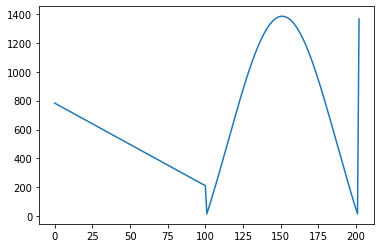

In [182]:
pyplot.plot(X[1])

Le graphique ci-dessus montre le vecteur des 3 variables du coté "input" dans le scale approprié.

[0.94800945 0.02956897 0.0150478  0.00734326]
AverageError on X for n= 4 : 0.02500285786680201


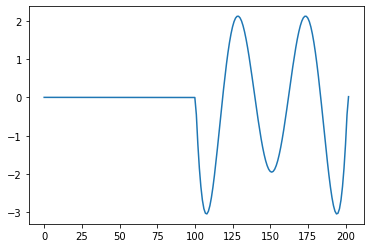

In [240]:
n=4
pca=PCA(n_components=n)
pca.fit(X)
print(pca.explained_variance_ratio_)
x3d=pca.transform(X)
Xhat=pca.inverse_transform(x3d)
pyplot.plot(X[1]-Xhat[1])
print('AverageError on X for n=',n,':',np.mean(np.abs(Ahat-A)))

4 composantes fittent bien nos données qui sont essentiellement décrites par n,a,lambdaB et kmax

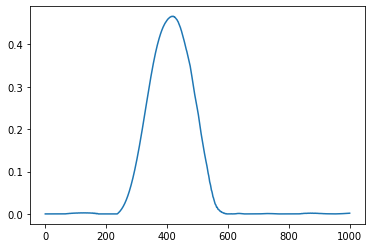

In [209]:
A=amplitudeLin
ADB=amplitudedB

n=20
pca=PCA(n_components=n)
A3d=pca.fit_transform(A)
Ahat=pca.inverse_transform(A3d)
Ahat[Ahat<1e-8]=1e-8
Ahat1=Ahat
pyplot.plot(Ahat1[1])

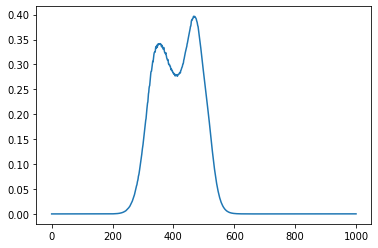

In [210]:
n=6
pca=PCA(n_components=n)
ADB3d=pca.fit_transform(ADB)
ADBhat=pca.inverse_transform(ADB3d)
Ahat2=10**(ADBhat/10)
pyplot.plot(Ahat2[1])

AverageError on A for n= 6 : 0.02500285786680201


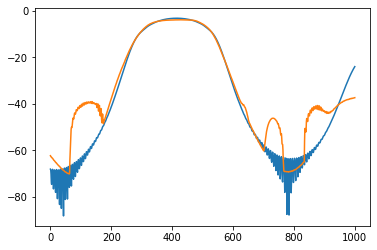

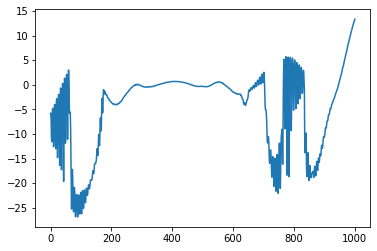

In [211]:
weights=Ahat1**(1/2)/np.max(Ahat1**(1/2))
Ahat=(Ahat1*weights+Ahat2*(1-weights))

AhatDB=10*np.log10(Ahat)
pyplot.figure()
pyplot.plot(ADB[1])
pyplot.plot(AhatDB[1])
pyplot.figure()
pyplot.plot(ADB[1]-AhatDB[1])
print('AverageError on A for n=',n,':',np.mean(np.abs(Ahat-A)))

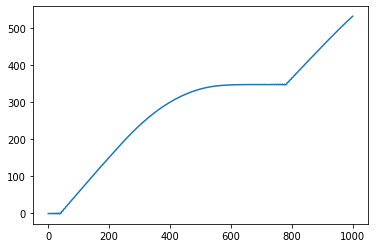

In [189]:
P=anglejm
pyplot.plot(P[1])

AverageError on P for n= 20 : 0.6725574


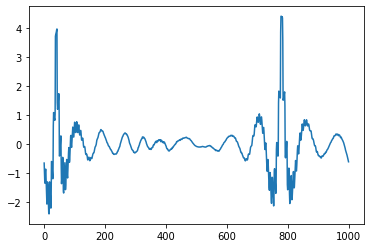

In [232]:
n=20
pca=PCA(n_components=n)
P3d=pca.fit_transform(P)
Phat=pca.inverse_transform(P3d)
pyplot.plot(Phat[1]-P[1])
print('AverageError on P for n=',n,':',np.mean(np.abs(Phat-P)))

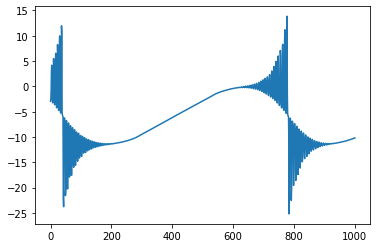

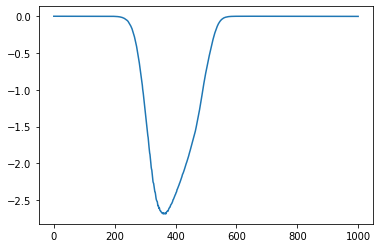

In [233]:
dP=np.gradient(P,axis=1)
dO=np.gradient(omega,axis=0)
dO.shape
G=dP/dO[None,:]*1e12
pyplot.plot(G[1])
pyplot.figure()
Gw=G*Ahat
pyplot.plot(Gw[1])

AverageError on Gw for n= 20 : 0.11314655727444412


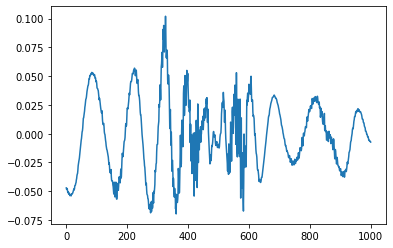

In [235]:
n=20
pca=PCA(n_components=n)
Gw3d=pca.fit_transform(Gw)
Gwhat=pca.inverse_transform(Gw3d)
pyplot.plot(Gwhat[1]-Gw[1])
print('AverageError on Gw for n=',n,':',np.mean(np.abs(Gwhat-Gw)))

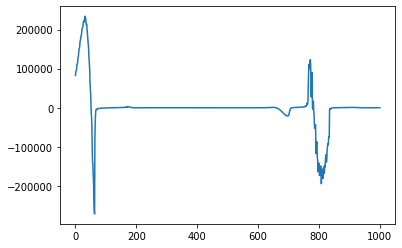

In [236]:
Ghat=Gwhat/Ahat
pyplot.plot(G[1]-Ghat[1])

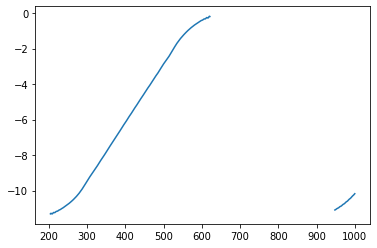

In [239]:
test=G[1]
test[A[1]<1e-4]=np.nan
pyplot.plot(test)